In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math
import os

#### Variables

In [ ]:
ROOT_DIR = 'dataset' # main dataset directory
DATA_DIR = '/consonants' # sub dataset directory, (vowels and consonants)

# Variables
FULL_DIR = ROOT_DIR+DATA_DIR # full path to the data directory
IMAGE_WIDTH = 28 # image width
IMAGE_HEIGHT = 28 # image height

### Load and split data

In [ ]:
def load_and_split_data(root_dir):
    all_labels = []

    num_of_directories = len(os.listdir(root_dir))
    categories = sorted(os.listdir(root_dir)[1:num_of_directories], key=lambda x: int(x))

    X_train, y_train = [], []
    X_val, y_val = [], []

    print(f"Loading data from {len(categories)} categories...")

    for category_id, category_name in enumerate(categories, 1):
        category_path = os.path.join(root_dir, category_name)

        # Check if the path is a directory
        if not os.path.isdir(category_path):
            continue

        print(f"  Processing folder: {category_name} (Category ID: {category_id})")

        # Get all image file paths in the current category
        image_files = [os.path.join(category_path, f)
                       for f in os.listdir(category_path)
                       if f.endswith('.jpg')]

        # Load the images for this category
        category_images = []
        for file_path in image_files:
            try:
                # Load image (mpimg.imread returns a numpy array)
                img = mpimg.imread(file_path)

                # Normalize pixel values to be between 0 and 1
                img = img.astype('float32') / 255.0

                category_images.append(img)
                all_labels.append(category_id)
            except Exception as e:
                print(f"    Error loading {file_path}: {e}")

        # Convert list of images to a NumPy array for easier slicing
        category_images_array = np.array(category_images)

        # Generate labels for this category
        category_labels = np.full(len(category_images_array), category_id)

        total_images_per_category = len(category_images_array)
        SPLIT = math.ceil(0.9 * total_images_per_category)

        train_data = category_images_array[:SPLIT]
        val_data = category_images_array[SPLIT:]

        train_labels = category_labels[:SPLIT]
        val_labels = category_labels[SPLIT:]

        # Append to the final lists
        X_train.extend(train_data)
        y_train.extend(train_labels)
        X_val.extend(val_data)
        y_val.extend(val_labels)

    print("\nData loading complete.")

    # Convert the final lists to NumPy arrays
    X_train = np.expand_dims(np.array(X_train), axis=-1)
    y_train = np.expand_dims(np.array(y_train), axis=-1)
    X_val = np.expand_dims(np.array(X_val), axis=-1)
    y_val = np.expand_dims(np.array(y_val), axis=-1)

    return X_train, y_train, X_val, y_val

# Execute the function
X_train, y_train, X_val, y_val = load_and_split_data(FULL_DIR)

Loading data from 36 categories...
  Processing folder: 1 (Category ID: 1)
  Processing folder: 2 (Category ID: 2)
  Processing folder: 3 (Category ID: 3)
  Processing folder: 4 (Category ID: 4)
  Processing folder: 5 (Category ID: 5)
  Processing folder: 6 (Category ID: 6)
  Processing folder: 7 (Category ID: 7)
  Processing folder: 8 (Category ID: 8)
  Processing folder: 9 (Category ID: 9)
  Processing folder: 10 (Category ID: 10)
  Processing folder: 11 (Category ID: 11)
  Processing folder: 12 (Category ID: 12)
  Processing folder: 13 (Category ID: 13)
  Processing folder: 14 (Category ID: 14)
  Processing folder: 15 (Category ID: 15)
  Processing folder: 16 (Category ID: 16)
  Processing folder: 17 (Category ID: 17)
  Processing folder: 18 (Category ID: 18)
  Processing folder: 19 (Category ID: 19)
  Processing folder: 20 (Category ID: 20)
  Processing folder: 21 (Category ID: 21)
  Processing folder: 22 (Category ID: 22)
  Processing folder: 23 (Category ID: 23)
  Processing fold

In [ ]:
# Decrease 1 for each training image to start index from 0
y_train = y_train - 1
y_val = y_val - 1

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

# Check the shapes
print("--- Verification ---")
print(f"Total Training Images: {len(X_train)}")
print(f"Total Validation Images: {len(X_val)}")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

--- Verification ---
Total Training Images: 6660
Total Validation Images: 720
X_train shape: (6660, 28, 28, 1)
y_train shape: (6660, 1)
X_val shape: (720, 28, 28, 1)
y_val shape: (720, 1)


#### Model

In [ ]:
def create_cnn_model(k, learning_rate = 0.15):
    # Input layer with shape (28, 28) and 1 channel
    inputs = Input((28, 28, 1))

    # 1 Convulational layer with ReLU activation
    conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    # 1 pooling layer
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    flattened = Flatten()(pool1)

    # 1 Hidden layer with 64 nodes and ReLU activation
    hidden1 = Dense(64, activation='relu')(flattened)
    # Output layer with k number of nodes (k is unique categories)
    out1 = Dense(k, activation='softmax')(hidden1)

    model = Model(inputs=inputs, outputs=out1)
    # SGD for optimization
    sgd = SGD(learning_rate=learning_rate)

    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    return model

In [ ]:
batch_size = 32

# Data agumentation for better accuracy and consistency
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Do not agument validation data so as to get accurate analysis of the model
val_datagen = ImageDataGenerator()

datagen.fit(X_train)
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

validation_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

k = 36 # for vowels 12, 36 for consonants
learning_rate = 0.01
model = create_cnn_model(k=k, learning_rate=learning_rate)

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,836 (1.33 MB)

 Trainable params: 348,836 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nb_epoch = 100
steps_per_epoch = math.ceil(len(X_train) / batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nb_epoch,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0333 - loss: 3.5802 - val_accuracy: 0.0569 - val_loss: 3.5654
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.0476 - loss: 3.5627 - val_accuracy: 0.0611 - val_loss: 3.5407
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0673 - loss: 3.5318 - val_accuracy: 0.1069 - val_loss: 3.4870
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0854 - loss: 3.4628 - val_accuracy: 0.0861 - val_loss: 3.3812
Epoch 5/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1084 - loss: 3.3398 - val_accuracy: 0.0903 - val_loss: 3.2209
Epoch 6/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1360 - loss: 3.1621 - val_accuracy: 0.1569 - val_loss: 2.9734
Epoch 7/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.1901 - loss: 2.9600 - val_accuracy: 0.1931 - val_loss: 2.7224
Epoch 8/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2293 - loss: 2.8062 - 

### Analysis

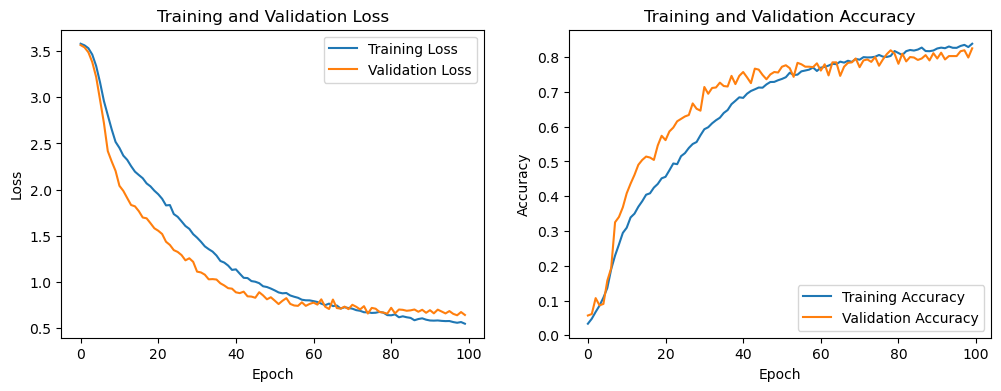

In [ ]:
def plot_history(history):
    # Get the loss and accuracy values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

plot_history(history)

In [153]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

Final Validation Loss: 0.6433
Final Validation Accuracy: 0.8250


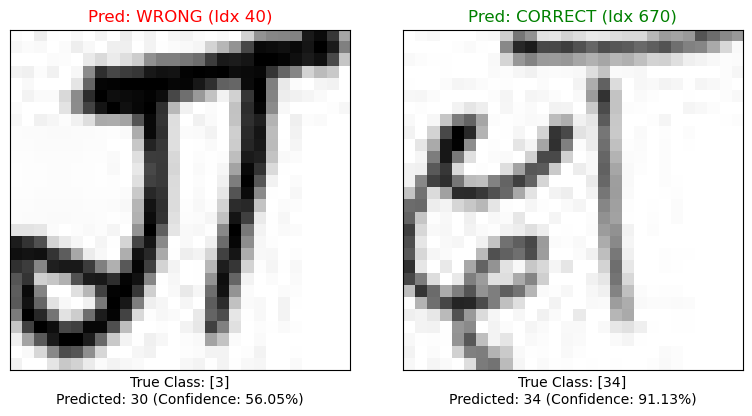

In [ ]:
indices_to_predict = [40, 670]

def predict_and_plot(index, subplot_position, X_val, y_val, model):
    """Predicts a single image and plots the result on a subplot."""

    single_image = X_val[index]
    true_label = y_val[index]

    image_for_prediction = np.expand_dims(single_image, axis=0)

    # Predict
    probabilities = model.predict(image_for_prediction, verbose=0)
    predicted_class = np.argmax(probabilities)
    confidence = probabilities[0, predicted_class] * 100

    readable_true_label = true_label + 1
    readable_predicted_class = predicted_class + 1

    is_correct = (predicted_class == true_label)
    result_text = "CORRECT" if is_correct else "WRONG"
    color = 'green' if is_correct else 'red'

    plt.subplot(1, 2, subplot_position)
    plt.imshow(single_image.squeeze(), cmap='gray')

    title_text = f"Pred: {result_text} (Idx {index})"
    xlabel_text = (f"True Class: {readable_true_label}\n"
                   f"Predicted: {readable_predicted_class} (Confidence: {confidence:.2f}%)")

    plt.title(title_text, color=color, fontsize=12)
    plt.xlabel(xlabel_text)
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(8, 4))

for i, index in enumerate(indices_to_predict):
    subplot_position = i + 1
    predict_and_plot(index, subplot_position, X_val, y_val, model)

plt.tight_layout()
plt.show()

In [ ]:
# Get probability predictions for all images in the validation set
probabilities = model.predict(X_val)

# The 'probabilities' array has a shape (number_of_val_samples, number_of_unique_categories)
print(f"Predictions shape: {probabilities.shape}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predictions shape: (720, 36)


In [ ]:
# Find the index (class) with the highest probability for each prediction
predicted_classes = np.argmax(probabilities, axis=1)

print(f"Predicted class labels (first 100): {predicted_classes[:100]}")

Predicted class labels (first 100): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  1  1  1  1
  1  1  1  1  1  1 25  1 29  1  1  1  1  1  1  1 29 29 29  2  2 14 14  2
  2 29  2  2  2  2  2  2  2  2  2  2 18  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3 22  4  4  4  4  4  4  4  4  4  4 12  4  4  4  4  4
  4  4  4  4]


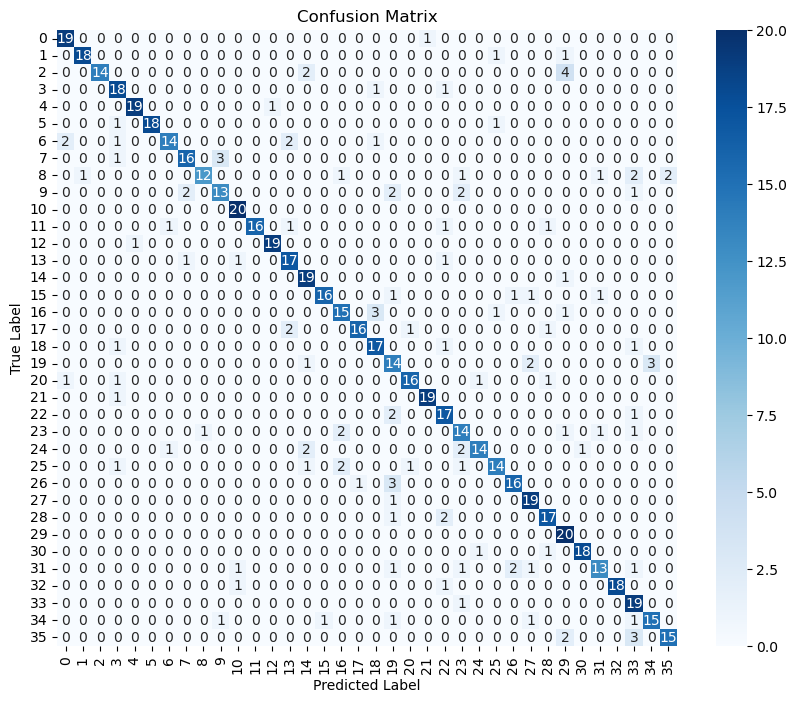

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_val, predicted_classes)

# Print the matrix and also plot it for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(36), yticklabels=range(36))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()